In [26]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# plotly visualization library
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly_express as px
from plotly import tools

# dimensionality decomposition libarires
from sklearn.decomposition import PCA
from umap import UMAP

#classifiers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# performance plotting
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold 
from itertools import product
from matplotlib.colors import ListedColormap
from scipy import interp

## Reading files and preprocessing

In [27]:
input_path = '../data/MovementAAL/dataset/MovementAAL_RSS_'
target_path = '../data/MovementAAL/dataset/MovementAAL_target.csv'
group_path = '../data/MovementAAL/groups/MovementAAL_DatasetGroup.csv'

### -------------------------------------------------------- loading files
file_dfs = []
file_lens = []

for i in range(1,315):
    file_path = input_path + str(i) + '.csv'
    file_df = pd.read_csv(file_path, header=0).reset_index(drop=True)
    file_df['_id'] = i 
    file_df = file_df.reset_index(drop=True)
    
   
    file_dfs.append(file_df)
    file_lens.append(file_df.shape[0])
    

input_df = pd.concat(file_dfs)
target_df = pd.read_csv(target_path)[' class_label']
group_df = pd.read_csv(group_path)[' dataset_ID']

gr_li = []
for idx, (id_num, target, group) in enumerate(zip(input_df['_id'].unique(), target_df, group_df)):
    gr = input_df[input_df['_id'] == id_num]
    gr = gr.reset_index(drop=True)
    gr['target'] = [target]*gr.shape[0]
    gr['group'] = [group]*gr.shape[0]
    gr['time'] = np.arange(0, gr.shape[0]/8, 1/8)
    gr_li.append(gr)


df = pd.concat(gr_li)
df = df.reset_index(drop=True)

# adding target label and group label
df['target_label'] = df['target'].apply(lambda x: 'Movement' if x==1 else 'Non-Movement')
df['group_label'] = (
                    np.select(condlist = [df['group']==1, df['group']==2, df['group']==3],
                             choicelist=['environment_1', 'environment_2', 'environment_3'])
                    )
# rearranging the columns
df = df.rename(columns={'#RSS_anchor1':'RSS_anchor1', ' RSS_anchor2':'RSS_anchor2', ' RSS_anchor3':'RSS_anchor3', ' RSS_anchor4':'RSS_anchor4'}) 

df = df[['_id', 'time', 'RSS_anchor1', 'RSS_anchor2', 'RSS_anchor3', 'RSS_anchor4',
        'target', 'target_label', 'group', 'group_label']]

# saving the preprocessed file
df.to_csv('../data/indoor_movement.csv', index = False)

## Visualization

In [28]:
df_red = df[df['_id'].isin(np.arange(25, 30))]
df_red.to_csv('../data/indoor_movement_red.csv', index = False)

# signal visulalization

for i in range(1,5):
    fig = px.line(df_red, x="time", y="RSS_anchor{}".format(i), color="target_label", line_group="_id", 
                  hover_name="target", line_shape="linear", width = 950, height = 550, line_dash = '_id',
                  facet_row = 'target_label', animation_frame = 'group_label', color_discrete_sequence = px.colors.qualitative.Alphabet)
    iplot(fig, filename= 'timeseries_{i}')


In [29]:
# histogram and density plot
for i in range(1,5):
    fig = px.histogram(df, x='RSS_anchor{}'.format(i), y='RSS_anchor{}'.format(i), color = 'target_label', facet_col = 'target_label', barmode = 'group', nbins=70, height = 400, width=990, color_discrete_sequence = px.colors.qualitative.Plotly[-7:-5])
    iplot(fig, filename= 'histogram_{i}')

In [ ]:
# dimensionality decomposition
input_cols = df[['RSS_anchor1', 'RSS_anchor2', 'RSS_anchor3', 'RSS_anchor4']]
target_col = df[['target_label']]
target_group = df[['group_label']]

pca = PCA(n_components=2, random_state=42)
umap = UMAP(n_components=2, random_state=42)

pca_res = pca.fit_transform(input_cols)
pca_res = pd.DataFrame(pca_res, columns = ['pc1', 'pc2'])
pca_res = pd.concat([pca_res, target_col,target_group], axis=1, sort = False)
pca_res = pca_res.sample(n=1000, random_state=42)


umap_res = umap.fit_transform(input_cols)
umap_res = pd.DataFrame(umap_res, columns = ['umap_x', 'umap_y'])
umap_res = pd.concat([umap_res, target_col,target_group], axis=1, sort = False)
umap_res = umap_res.sample(n=1000, random_state=42)

In [ ]:
fig = px.scatter(pca_res, x="pc1", y="pc2", color="target_label", 
              hover_name="target_label", width = 990, height = 500,
           color_discrete_sequence = px.colors.qualitative.Vivid, facet_col = 'group_label', size_max=5
              )
iplot(fig, filename='pca')

In [ ]:
fig = px.scatter(umap_res, x="umap_x", y="umap_y", color="target_label", 
              hover_name="target_label", width = 990, height = 550,
           color_discrete_sequence = px.colors.qualitative.Vivid, animation_frame='group_label',
              )
iplot(fig, filename='umap')

## Classification

In [ ]:
X = df[['RSS_anchor1', 'RSS_anchor2', 'RSS_anchor3', 'RSS_anchor4']]
y = df['target']


### Baseline Classifier (Random Forest)

In [ ]:
X = df[['RSS_anchor1', 'RSS_anchor2', 'RSS_anchor3', 'RSS_anchor4']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('validation score of baseline classifier: {}{}'.format(round(score*100,3), '%'))

validation score of baseline classifier: 73.788%


### Improving the Baseline Accuracy with Ensembling and Cross validation

In [ ]:
# TConstructing an ensemble classifier
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = GradientBoostingClassifier()
clf4 = RandomForestClassifier(n_estimators=100)
clf5 = AdaBoostClassifier()
eclf = VotingClassifier(estimators=[('decision_tree', clf1), ('knn', clf2),('gradient_boosting', clf3), ('random_forest', clf4), ('adaboost', clf5)],
                        voting='soft', weights=[3, 3, 3, 2, 1])

score_list = []
i = 0
cv = StratifiedKFold(n_splits=10)
for train, test in tqdm(cv.split(X.values, y.values.ravel())):
    eclf.fit(X.values[train], y.values.ravel()[train])
    score = eclf.score(X_test, y_test)
    score_list.append(score)

score = sum(score_list)/10
print('validation score of ensemble classifier with cross validation: {}{}'.format(round(score*100,3), '%'))

10it [00:16,  1.60s/it]

validation score of ensemble classifier with cross validation: 81.97%


### ROC curve of Ensemble Classifier

10it [00:16,  1.67s/it]


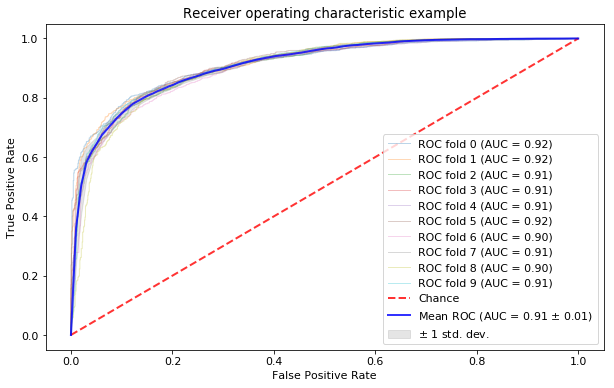

In [ ]:
plt.rcParams.update({'font.size': 11})
plt.rc('xtick', labelsize=11) 
plt.rc('ytick', labelsize=11) 
cv = StratifiedKFold(n_splits=10)
classifier = eclf

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(10,6))
i = 0
for train, test in tqdm(cv.split(X, y)):
    probas_ = classifier.fit(X.values[train], y.values.ravel()[train]).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    px

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Decision Boundary Plot of Ensemble Classifier

In [ ]:
X = df[['RSS_anchor1', 'RSS_anchor2', 'RSS_anchor3', 'RSS_anchor4']]
y = df['target']
X_umap = umap.fit_transform(X)
X_umap = pd.DataFrame(X_umap, columns = ['umap_x', 'umap_y'])
y_umap = y
y_umap = pd.DataFrame(y_umap, columns=['target'])

Xy_umap = pd.concat([X_umap, y_umap], axis = 1).sample(n=300, random_state=42)
X_umap_red = Xy_umap[['umap_x', 'umap_y']]
y_umap_red = Xy_umap[['target']]

X = X_umap_red.values
y = y_umap_red.values.ravel()

clf1.fit(X,y)
clf2.fit(X,y)
clf3.fit(X,y)
clf4.fit(X,y)
clf5.fit(X,y)
eclf.fit(X,y)

In [ ]:
titles =  ('Decision Tree (depth=4)', 'KNN (k=7)',
           'Gradient Boosting', 'Random Forest', 'AdaBoost', 'Ensemble')

fig = tools.make_subplots(rows=3, cols=2,
                          print_grid=False,
                          subplot_titles=titles
                         )

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
y_ = np.arange(y_min, y_max, 0.1)

for idx, clf in zip([(0,0),(0,1), (1,0), (1,1), (2,0), (2,1)],
                    [clf1, clf2, clf3, clf4, clf5, eclf]):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    trace1 = go.Contour(x=xx[0], y=y_, 
                        z=Z,
                        colorscale=[
                                    [0, 'rgb(229, 134, 6)'],
                                    [1, 'rgb(93, 105, 177)']
                                   ],
                        opacity=0.15,
                        showscale=False
                        )
    trace2 = go.Scatter(x=X[:, 0], y=X[:, 1], 
                        showlegend=False,
                        mode='markers',
                        marker=dict(color=y, colorscale = [
                                    [0, 'rgb(229, 134, 6)'],
                                    [1, 'rgb(93, 105, 177)']
                                   ], showscale=True,
                                    line=dict(color='black', width=1)
                                    )
                       )
    
    fig.append_trace(trace1, idx[0]+1, idx[1]+1)
    fig.append_trace(trace2, idx[0]+1, idx[1]+1)
    
fig['layout'].update(height=1200, hovermode='closest')

for i in map(str, list(range(1,7))):
    x = 'xaxis' + i
    y = 'yaxis' + i
    fig['layout'][x].update(showgrid=False, zeroline=False)
    fig['layout'][y].update(showgrid=False, zeroline=False)




In [ ]:
iplot(fig)